#🌋HYPERPARAMETER



In [1]:
### HYPERPARAMETER ###

from google.colab import drive, userdata
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = userdata.get("gdrive_seo_root")
PROJECT_ROOT_ESC_STR = PROJECT_ROOT.replace('Colab Notebooks', 'Colab\ Notebooks')
SRC_PATH, DATA_PATH = PROJECT_ROOT + "/src", PROJECT_ROOT + "/data"
START_URL = "https://www.rue-zahnspange.de/"
EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]


Mounted at /content/drive


In [2]:
DATA_PATH

'/content/drive/MyDrive/Colab Notebooks/SEO/data'

# 🏁 Install requirements + dependencies

In [3]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/notebooks/Installation.ipynb'

In [4]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/src/dependencies.py'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# ⛩ push to github

In [ ]:
import github
importlib.reload(github)
from github import GitHubManager

# Starte den GitHub-Sync
git_manager = GitHubManager(
    userdata.get("github_pat"),
    userdata.get("github_email"),
    userdata.get("github_username"),
    userdata.get("github_repo_seo"),
    PROJECT_ROOT_ESC_STR
)

git_manager.clone_repo()  # Klonen des Repos
git_manager.sync_project()

📥 Klonen des GitHub-Repositories...
📂 Kopiere das Projekt ins Repository...


# 🕸 scrap

In [ ]:
import webscraper
importlib.reload(webscraper)
from webscraper import WebsiteScraper

scraper = WebsiteScraper(start_url=START_URL, max_pages=20, excluded_keywords=EXCLUDED_KEYWORDS)

original_texts = scraper.get_filtered_texts()

# 📺 google ads

In [ ]:
!pip install google-ads

In [ ]:
config = {
    "developer_token": "AUtGfqeDgT-yEyR52oi0EQ",
    "client_id": "1077725291932-uqdhpv4776pp9io3ovlqojk2fh9elqnn.apps.googleusercontent.com",
    "client_secret": "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",
    "refresh_token": "1//04nOBQT2hsGVdCgYIARAAGAQSNwF-L9Ir8K81n8T9j03mlEZm69VgidaWI6dHApllPM_0xTIJs3wGiQT0vaLkYuSrIaIkbLQi9JE",
    "login_customer_id": "2262766246",
    "use_proto_plus":False
}


In [ ]:

config = {
    "developer_token": "AUtGfqeDgT-yEyR52oi0EQ",
    "client_id": "1077725291932-uqdhpv4776pp9io3ovlqojk2fh9elqnn.apps.googleusercontent.com",
    "client_secret": "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",
    "refresh_token": "1//04nOBQT2hsGVdCgYIARAAGAQSNwF-L9Ir8K81n8T9j03mlEZm69VgidaWI6dHApllPM_0xTIJs3wGiQT0vaLkYuSrIaIkbLQi9JE"
}

In [ ]:
!pip install google_ads

In [ ]:
from google.ads.google_ads.client import GoogleAdsClient

# Google Ads Client laden
client = GoogleAdsClient.load_from_dict(config)

print("Google Ads API erfolgreich verbunden!")

# 🔮webtext analysis + SEO

In [ ]:
import llmprocessor
importlib.reload(llmprocessor)
from llmprocessor import LLMProcessor

llm_processor = LLMProcessor(PROJECT_ROOT, original_texts)

optimized_texts = llm_processor.run_all()


=== Analyzing https://www.rue-zahnspange.de/ ===
Analyse

Der vorhandene Text bietet eine solide Grundlage, um die Dienstleistungen der kieferorthopädischen Praxis RÜ in Essen vorzustellen. Allerdings fehlen strategisch platzierte SEO-Keywords, die die Auffindbarkeit der Website in Suchmaschinen verbessern können. Zudem könnte die Struktur des Textes für eine bessere Lesbarkeit und Nutzererfahrung optimiert werden. Es fehlt an Meta-Titeln und Longtail-Keywords, die gezielt für Suchanfragen in der Kieferorthopädie relevant sind. Insgesamt sollte der Text natürlicher und zugänglicher klingen, ohne dass es zu einem übertriebenen Einsatz von Keywords kommt, was als Keyword-Stuffing angesehen werden könnte.

SEO

Moderne Zahnspangen für ein strahlendes Lächeln in Essen, Rüttenscheid

Willkommen in der Kieferorthopädie-Praxis RÜ in Essen, Rüttenscheid. Entdecken Sie unsere vielseitigen Behandlungen für Kinder und Jugendliche, die Ihre Kiefergesundheit optimieren und ein langanhaltendes, ges

# 📁 Textprozessor

In [ ]:
import textprocessor
importlib.reload(textprocessor)
from textprocessor import TextProcessor

# JSON mit den SEO-Abschnitten extrahieren
json_output = TextProcessor.extract_sections_to_json(list(optimized_texts.keys()), list(optimized_texts.values()))
seo_json = json.loads(json_output)

# texte bereinigen und hinzufügen
seo_json = TextProcessor.add_cleaned_text(seo_json, original_texts)

# Ergebnis anzeigen
print(json.dumps(seo_json, indent=4, ensure_ascii=False))


{
    "https://www.rue-zahnspange.de/": {
        "Analyse": "Der vorhandene Text bietet eine solide Grundlage, um die Dienstleistungen der kieferorthopädischen Praxis RÜ in Essen vorzustellen. Allerdings fehlen strategisch platzierte SEO-Keywords, die die Auffindbarkeit der Website in Suchmaschinen verbessern können. Zudem könnte die Struktur des Textes für eine bessere Lesbarkeit und Nutzererfahrung optimiert werden. Es fehlt an Meta-Titeln und Longtail-Keywords, die gezielt für Suchanfragen in der Kieferorthopädie relevant sind. Insgesamt sollte der Text natürlicher und zugänglicher klingen, ohne dass es zu einem übertriebenen Einsatz von Keywords kommt, was als Keyword-Stuffing angesehen werden könnte.",
        "SEO": "Moderne Zahnspangen für ein strahlendes Lächeln in Essen, Rüttenscheid Willkommen in der Kieferorthopädie-Praxis RÜ in Essen, Rüttenscheid. Entdecken Sie unsere vielseitigen Behandlungen für Kinder und Jugendliche, die Ihre Kiefergesundheit optimieren und ein langan

# 📊SEO Analysis


🔍 Wortfrequenz-Vergleich:
🔹 Wortfrequenz-Differenzen für Text 1:
kieferorthopädie: 3
zur: 3
essen,: 2
sprechen: 1
beliebt: 1
essentiell: 1
mundgesundheit.: 1
individuellen: 1
traumlächeln.: 1
abläufen.: 1
🔹 Wortfrequenz-Differenzen für Text 2:
in: 10
und: 7
sie: 6
essen-rüttenscheid: 4
eine: 4
diese: 4
sind: 4
kieferorthopädie: 3
unsere: 3
komfortablen: 3
🔹 Wortfrequenz-Differenzen für Text 3:
in: 8
bei: 3
zahnbehandlungen: 2
essen: 2
wir: 2
rüttenscheid: 2
essen,: 2
rü: 2
schmerzfreier: 1
entscheidend: 1
🔹 Wortfrequenz-Differenzen für Text 4:
in: 9
für: 6
ihre: 4
und: 4
mit: 3
zahnkorrekturen: 2
die: 2
bei: 2
kieferorthopädie: 2
wir: 2
🔹 Wortfrequenz-Differenzen für Text 5:
kieferorthopädie: 3
wir: 3
ihrer: 3
für: 3
ihr: 2
die: 2
zu: 2
von: 2
essen-rüttenscheid: 2
uns: 2

🔍 Berechnung der Similarities:
📊 Durchschnittliche Similarities (Original -> Keywords): [0.06508754 0.00926513 0.05527503 0.02059504 0.04553374 0.00595022
 0.         0.02298108 0.00645475 0.03600672]
📊 Durchschnitt

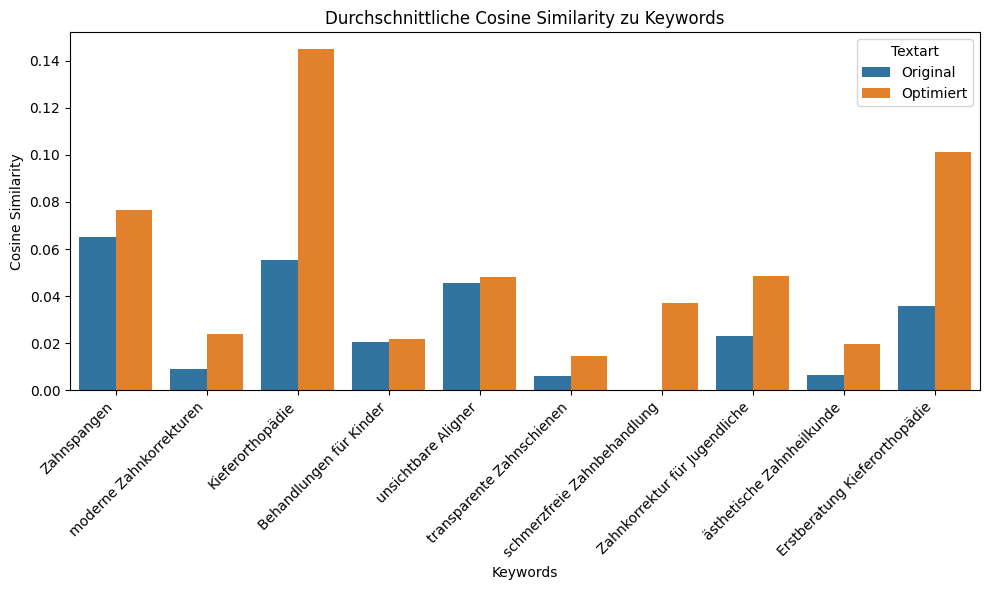


📊 Visualisierung der Keyword-Häufigkeiten:


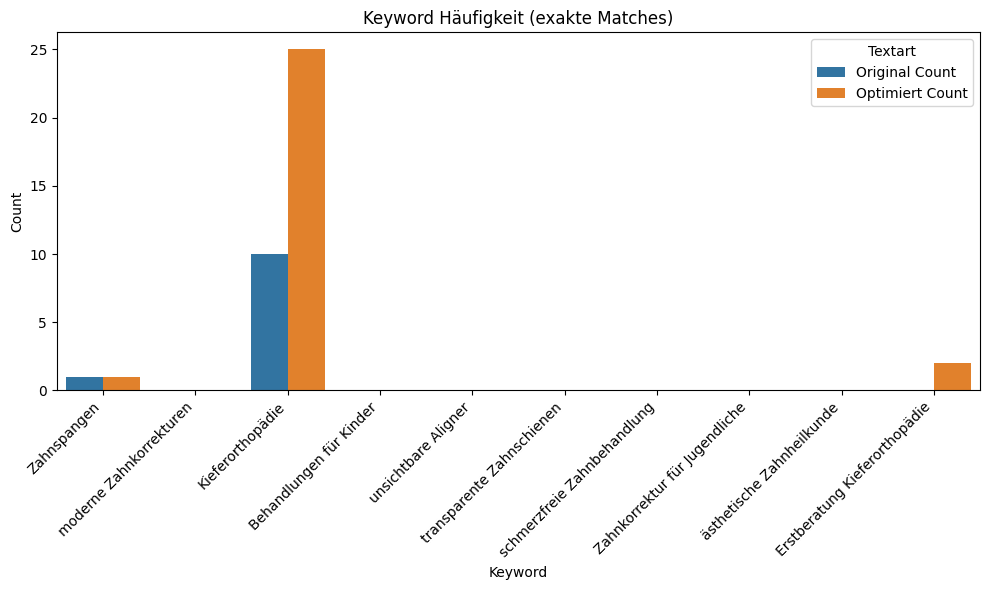


☁️ Wordcloud-Visualisierung:


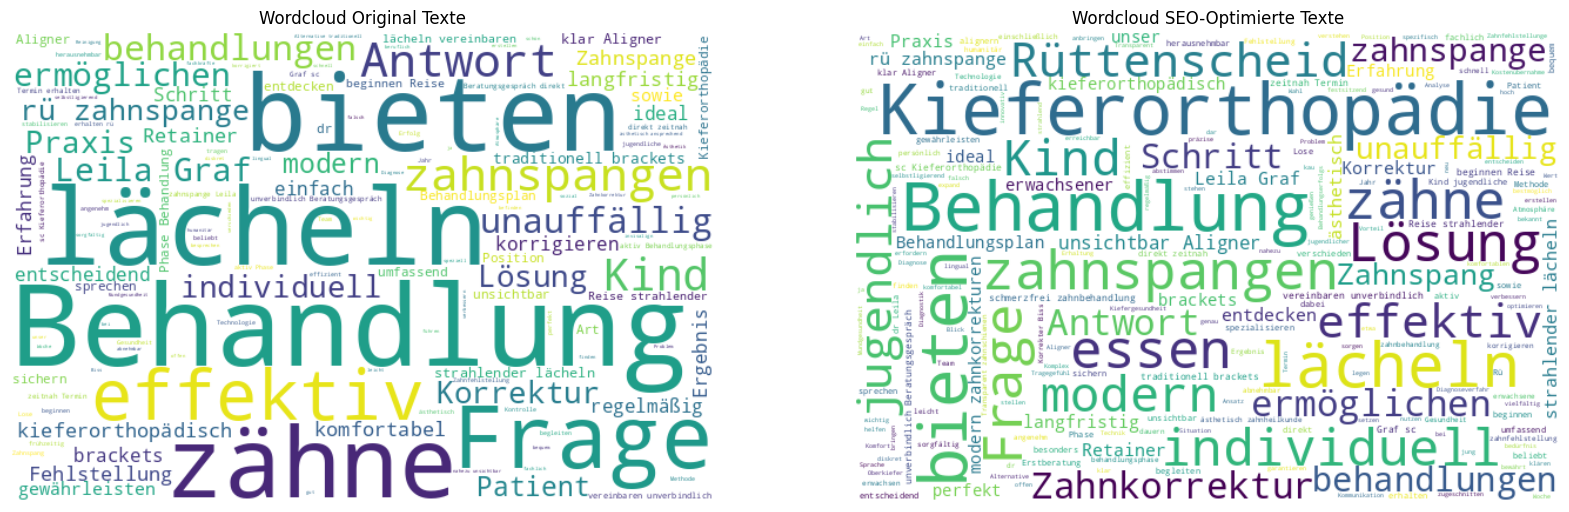

In [ ]:
import seoanalyzer
importlib.reload(seoanalyzer)
from seoanalyzer import SEOAnalyzer

keywords_final = json.loads(llm_processor.get_keywords()['keywords_final'])
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()


# ▶ conversion rates, modelierungen

In [ ]:
# Historische SEO-Daten
historical_data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]
}


📊 Historische SEO-Trends


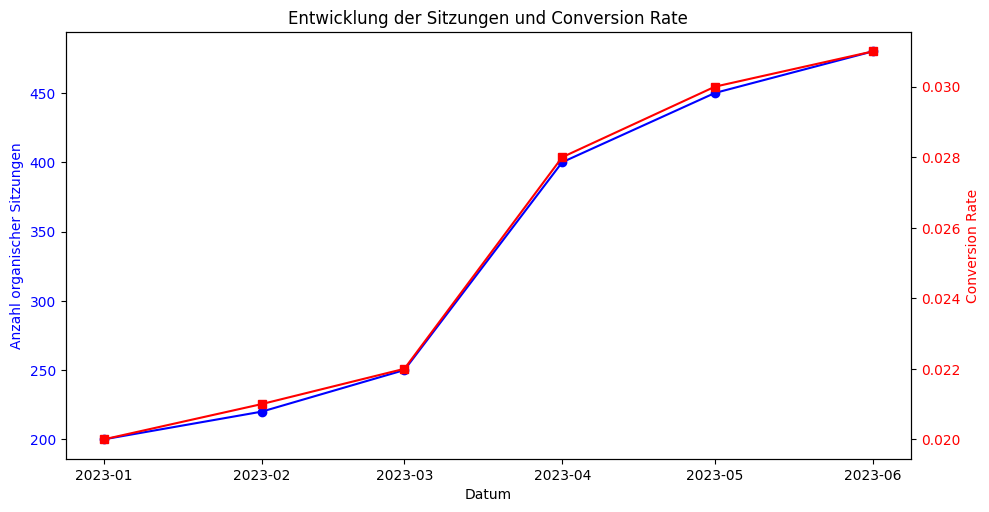

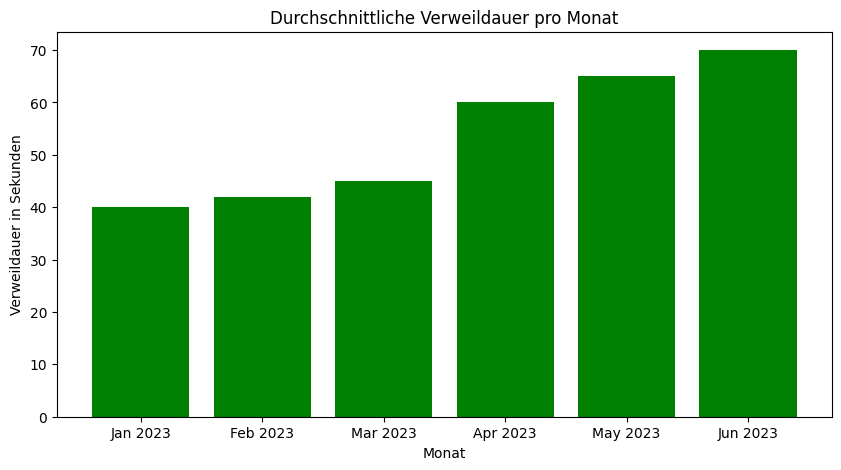


📈 Prognose der organischen Sitzungen


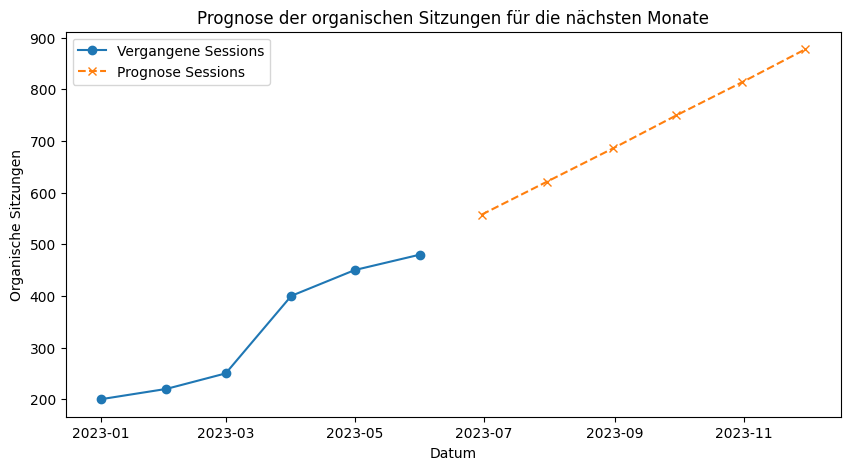


📈 Prognose der Conversion-Rate


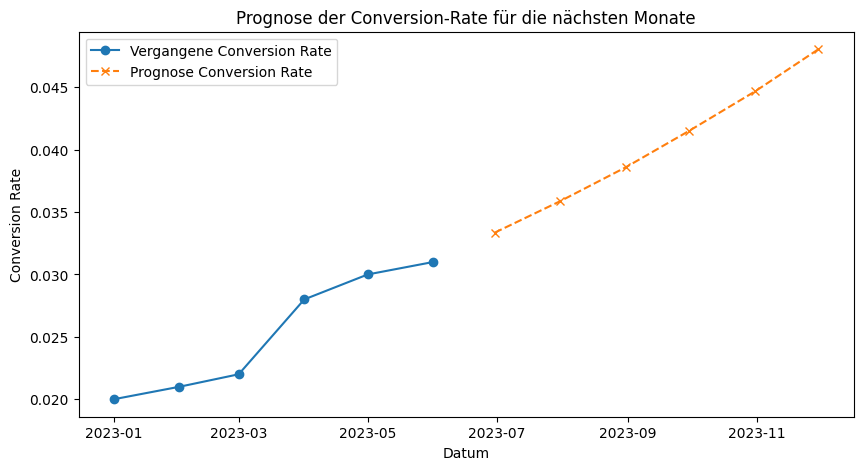

In [ ]:
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final, historical_data)
seo_analyzer.run_models()

# 🛏 embedding demo


📊 3D-Keyword Similarity


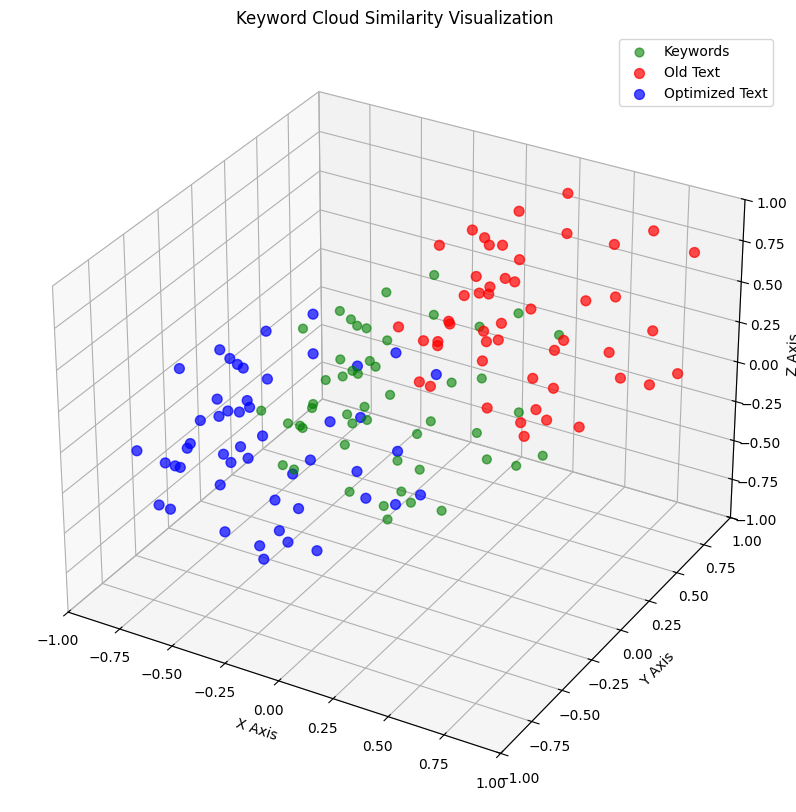


🔍 Cosine Similarity Steps


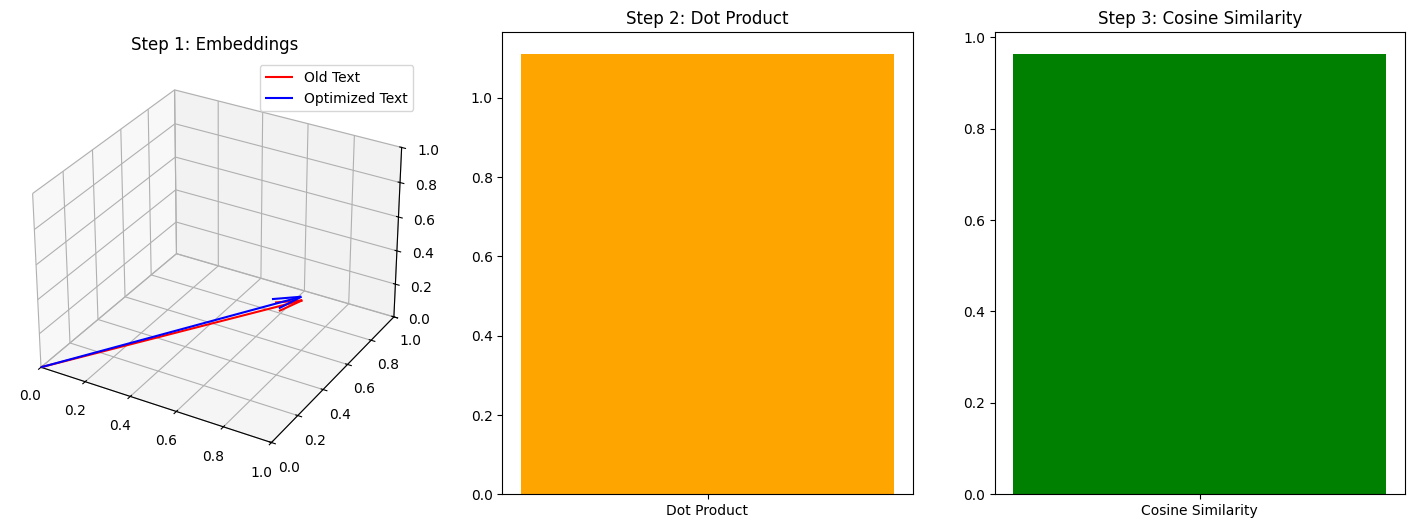


🔍 Cosine Comparision


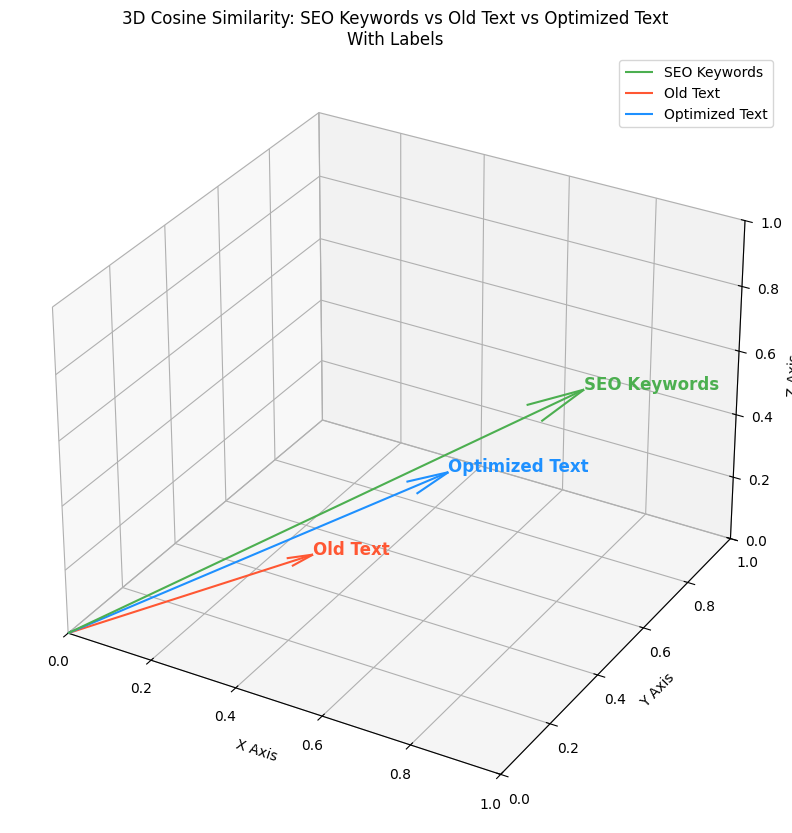


📌 3D BERT Embedding Visualization


In [ ]:
import embeddingdemo
importlib.reload(embeddingdemo)
from embeddingdemo import EmbeddingDemo

demo = EmbeddingDemo()
demo.run_all_visualizations()

# ⛳ json to pdf + docx

In [ ]:
%%capture
def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [ ]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template mit EINER Spalte für "SEO" (die "alt"-Spalte entfällt)
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            /* Zeilenumbrüche aus dem JSON in <br> wandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>

        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- "Analyse" normal untereinander -->
            <p class="header">Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <!-- "Erklärung" normal untereinander -->
            <p class="header">Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <!-- NUR noch die "SEO"-Spalte -->
            <div class="column">
                <p class="header">SEO</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(data=json_data)


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [ ]:
async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

PDF mit Playwright erstellt.


In [ ]:
input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


Konvertierung nach DOCX abgeschlossen.


# 📥 RAG

In [ ]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

"Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen."

"Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. "

"behandlungsorientierte Zahnberatung"

"ästehthetisches Lächeln"

"Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde" "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde"

"Der aktuelle Text zur Zahnspangenpraxis"

"Kieferorthopäde in [Ihre Stadt]"

'Kieferorthopäde in [Ihre Stadt]'

In [ ]:
# faiss_index_path = userdata.get('gdrive_seo_folder') + '/faiss_index'
# vector_store.save_local(faiss_index_path)

In [ ]:
# FAISS.load_local(faiss_index_path, embeddings, allow_dangerous_deserialization=True)

In [ ]:
%%capture

def chunk_text_2(text, chunk_size=500):
    """
    Beispiel: einfach alle 500 Zeichen ein Chunk.
    Für echte Token-Logik kann man tiktoken oder langchain-Splitter nutzen.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end
    return chunks

chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    text_chunks = chunk_text_2(seo_text, chunk_size=500)
    chunked_texts.append(text_chunks)

# chunked_texts = [
#   [chunk1_of_text1, chunk2_of_text1, ...],
#   [chunk1_of_text2, ...],
#   ...
# ]


NameError: name 'page_text_list' is not defined

In [ ]:
%%capture

def get_context_from_vector_store(chunk):
    """
    Sucht im FAISS-Index nach passenden Dokumenten zum gegebenen Chunk,
    z. B. bekannte Fehler, die diesem Chunk ähneln.
    """
    # top_k=2 oder so, je nach Bedarf
    results = vector_store.similarity_search(chunk, k=2)
    # results ist eine Liste von Document-Objekten

    # Wir wollen z. B. den Inhalt zusammenfügen als "Kontext":
    context_text = "\n---\n".join([doc.page_content for doc in results])
    return context_text

# Beispielhafte Abfrage pro Chunk
# test_chunk = chunked_texts[0][0]  # Erster Chunk des ersten Textes
# retrieved_context = get_context_from_vector_store(test_chunk)
# print("Kontext aus Vektorindex:\n", retrieved_context)


In [ ]:
%%capture

import json

def proofread_text_with_context(chunk, context):
    """
    Fragt ChatGPT (mittels der Chatbot-Klasse) an, um den Textchunk auf Fehler zu prüfen und zu korrigieren.
    Nutzt den Kontext aus dem Vector Store, um bekannte Fehler zu berücksichtigen.

    Erwartete Antwortstruktur (JSON):

    {
      "corrected_text": "...",
      "new_mistakes_found": [
        {
          "description": "Beschreibung des neuen Fehlers",
          "original_snippet": "Die fehlerhafte Passage"
        },
        ...
      ]
    }
    """

    # 1. System Prompt
    system_prompt = (
        "Du bist ein professioneller Lektor und Grammatik-Experte. "
        "Du kennst deutsche Grammatik, Rechtschreibung und eingedeutschte Fachbegriffe."
    )

    # 2. User Prompt
    #    Wir kombinieren den Kontext und unseren zu prüfenden Text, plus
    #    die Anweisung, nur JSON auszugeben.
    user_prompt = f"""
Im Folgenden siehst du bereits bekannte Fehlerhinweise (Kontext). Nutze diese Infos,
um den Text zu prüfen und zu korrigieren. Solltest du neue Fehler (Grammatik,
falsch eingedeutschte Worte, Satzstellung etc.) finden, liste sie gesondert auf.

Bekannte Fehler (Kontext):
{context}

Text zur Prüfung:
{chunk}

Anweisung:
1) Analysiere den Text gründlich auf sprachliche/grammatische Fehler.
2) Nutze ggf. den Kontext.
3) Korrigiere diese Fehler im Text, ohne den Sinn zu verändern.
4) Liste alle neu gefundenen Fehler (noch nicht im Kontext) zusätzlich auf.
5) Antworte in folgendem JSON-Format (ohne weitere Worte davor oder danach!):

{{
  "corrected_text": "TEXTVERSION KORRIGIERT",
  "new_mistakes_found": [
    {{
      "description": "Beschreibung des Fehlers",
      "original_snippet": "Snippet der Original-Passage"
    }}
  ]
}}
"""

    # 3. Chatbot verwenden:
    cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)

    # Da wir keine Streaming-Ausgabe brauchen, nutzen wir hier `chat()` statt `chat_with_streaming()`.
    response_raw = cb.chat()

    # 4. JSON parsen
    try:
        parsed = json.loads(response_raw)
        # parsed = {
        #   "corrected_text": "...",
        #   "new_mistakes_found": [...]
        # }
        return parsed

    except json.JSONDecodeError:
        print("Fehler: ChatGPT hat kein gültiges JSON zurückgegeben.")
        return {
            "corrected_text": "Fehler: Keine gültige JSON-Antwort.",
            "new_mistakes_found": []
        }


In [ ]:
%%capture
all_corrected_texts = []
all_new_mistakes = []

#for text_chunks in chunked_texts:  # => Jede Liste von Chunks (pro SEO-Text)
#    corrected_text_chunks = []

#    for chunk in text_chunks:
#        # 3a) Kontext abfragen
#        context = get_context_from_vector_store(chunk)
#
#
#       # 4a) Prompt ChatGPT (Korrektur)
#        result = proofread_text_with_context(chunk, context)
#
#        corrected_text = result["corrected_text"]
#        new_mistakes = result["new_mistakes_found"]
#
#        # Sammeln
#        corrected_text_chunks.append(corrected_text)
#        all_new_mistakes.extend(new_mistakes)
#
#    # Pro SEO-Text fügen wir die korrigierten Chunks zusammen.
#    full_corrected_text = "\n".join(corrected_text_chunks)
#    all_corrected_texts.append(full_corrected_text)

# Jetzt haben wir:
# all_corrected_texts = [ "korrigierter SEO Text Nr.1", "korrigierter SEO Text Nr.2", ...]
# all_new_mistakes = Liste aller neu gefundenen Fehler


In [ ]:
%%capture
# for _ in all_corrected_texts:
#   print(_)

In [ ]:
# all_new_mistakes